In [1]:
import numpy as np
import pandas as pd
from src.timesfm import data_loader
from tqdm import tqdm
import os

import matplotlib.pyplot as plt

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.
Loaded PyTorch TimesFM.


/home/v-zhangjiaw/miniconda3/envs/timesfm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded Jax TimesFM.
Loaded PyTorch TimesFM.


2024-12-29 11:24:25.442281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735471465.455720 3396258 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735471465.459954 3396258 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
DATA_DICT = {
    "ettm2": {
        "boundaries": [34560, 46080, 57600],
        "data_path": "./datasets/ETT-small/ETTm2.csv",
        "freq": "15min",
    },
    "ettm1": {
        "boundaries": [34560, 46080, 57600],
        "data_path": "./datasets/ETT-small/ETTm1.csv",
        "freq": "15min",
    },
    "etth2": {
        "boundaries": [8640, 11520, 14400],
        "data_path": "./datasets/ETT-small/ETTh2.csv",
        "freq": "H",
    },
    "etth1": {
        "boundaries": [8640, 11520, 14400],
        "data_path": "./datasets/ETT-small/ETTh1.csv",
        "freq": "H",
    },
    "elec": {
        "boundaries": [18413, 21044, 26304],
        "data_path": "./datasets/electricity/electricity.csv",
        "freq": "H",
    },
    "traffic": {
        "boundaries": [12280, 14036, 17544],
        "data_path": "./datasets/traffic/traffic.csv",
        "freq": "H",
    },
    "weather": {
        "boundaries": [36887, 42157, 52696],
        "data_path": "./datasets/weather/weather.csv",
        "freq": "10min",
    },
}

# Get Datasets

In [3]:
def get_dataset(dataset, context_len, pred_len, batch_size):
    data_path = DATA_DICT[dataset]["data_path"]
    freq = DATA_DICT[dataset]["freq"]
    # int_freq = timesfm.freq_map(freq)
    boundaries = DATA_DICT[dataset]["boundaries"]

    data_df = pd.read_csv(open(data_path, "r"))


    ts_cols = [col for col in data_df.columns if col != "date"]
    num_cov_cols = None
    cat_cov_cols = None

    num_ts = len(ts_cols)
    
    dtl = data_loader.TimeSeriesdata(
        data_path=data_path,
        datetime_col="date",
        num_cov_cols=num_cov_cols,
        cat_cov_cols=cat_cov_cols,
        ts_cols=np.array(ts_cols),
        train_range=[0, boundaries[0]],
        val_range=[boundaries[0], boundaries[1]],
        test_range=[boundaries[1], boundaries[2]],
        hist_len=context_len,
        pred_len=pred_len,
        batch_size=num_ts,
        freq=freq,
        normalize=True,
        epoch_len=None,
        holiday=False,
        permute=True,
    )
    train_batches = dtl.tf_dataset(mode="train", shift=1).batch(batch_size)
    val_batches = dtl.tf_dataset(mode="val", shift=pred_len)
    test_batches = dtl.tf_dataset(mode="test", shift=pred_len)
    
    return train_batches, val_batches, test_batches

# Load Model

In [4]:
context_length = 256
prediction_length = 96
batch_size = 32
dataset = "etth1"

In [22]:
from timesfm_torch.model.timesfm import TimesFm as TimesFm_pt

tfm_pt = TimesFm_pt(
	context_len=context_length,
	input_patch_len=batch_size,
	output_patch_len=prediction_length,
	# horizon_len=prediction_length
	)

In [23]:
from src import timesfm

tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="gpu",
        per_core_batch_size=32,
        horizon_len=prediction_length,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
)



Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 40459.52it/s]

In [42]:
tfm_pt_dict = tfm_pt.state_dict()

In [13]:
tfm_dict = tfm._model.state_dict()

In [64]:
# 文件路径
output_file = "tfm_dict_keys.txt"

# 将所有键写入文本文件
with open(output_file, "w") as f:
    for key in tfm_dict.keys():
        f.write(key + "\n")


In [37]:
# 筛选出所有 'input_ff_layer' 开头的键
input_ff_keys = [key for key in tfm_dict.keys() if key.startswith('horizon_ff_layer')]

# Inference

In [103]:
mae_losses = []
mse_losses = []

forecasts_list = []
quantile_forecasts_list = []
pred_target = []
input_data = []

train_batches, val_batches, test_batches = get_dataset(dataset, context_length, prediction_length, batch_size)
for batch in test_batches.as_numpy_iterator():
    past = batch[0]
    actuals = batch[3]
    forecasts, quantile_forecasts = tfm.forecast(list(past), [0] * past.shape[0], normalize=True)
    forecasts = forecasts[:, 0 : actuals.shape[1]]
     
    input_data.append(past)
    pred_target.append(actuals)
    forecasts_list.append(forecasts)
    quantile_forecasts_list.append(quantile_forecasts)
    
    mse_losses.append(np.mean(np.square(forecasts - actuals)))
    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}, MSE: {np.mean(mse_losses)}")

/home/v-zhangjiaw/code/timesfm/src/timesfm/data_loader.py:90: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.date_range(


MAE: 0.40174615383148193, MSE: 0.4404239058494568


# Visualization

In [104]:
input_data = np.array(input_data) # [batch_size, var_num, context_length]
pred_target = np.array(pred_target) # [batch_size, var_num, pred_length]
forecasts_list = np.array(forecasts_list) # [batch_size, var_num, pred_length]
quantile_forecasts_list = np.array(quantile_forecasts_list) # [batch_size, var_num, pred_length, quantile_num]

In [105]:
def plot_results_with_quantile(input_data, target_data, forecast_df):
    y_median = forecast_df[:, 5]  # 中位数（q=0.5）
    y_lower = forecast_df[:, 1]  # 最低分位数（q=0.1）
    y_upper = forecast_df[:, 9]  # 最高分位数（q=0.9）

    y_ground_truth = target_data
    
    y_ground_truth_past = input_data
    x_ground_truth_past = range(len(input_data))
    
    x = range(len(input_data), len(input_data) + len(target_data))

    plt.figure(figsize=(12, 6))
    plt.plot(x, y_median, label="Median Prediction (q=0.5)", color="green", linestyle="--")

    # Uncertainty
    plt.fill_between(x, y_lower, y_upper, color="green", alpha=0.2, label="Uncertainty (q=0.1 - q=0.9)")

    # Ground Truth
    plt.plot(x, y_ground_truth, label="Ground Truth (Target)", color="black")
    plt.plot(x_ground_truth_past, y_ground_truth_past, color="black")


    plt.ylabel("Forecast Value", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)  

    # 显示图形
    plt.tight_layout()
    plt.show()

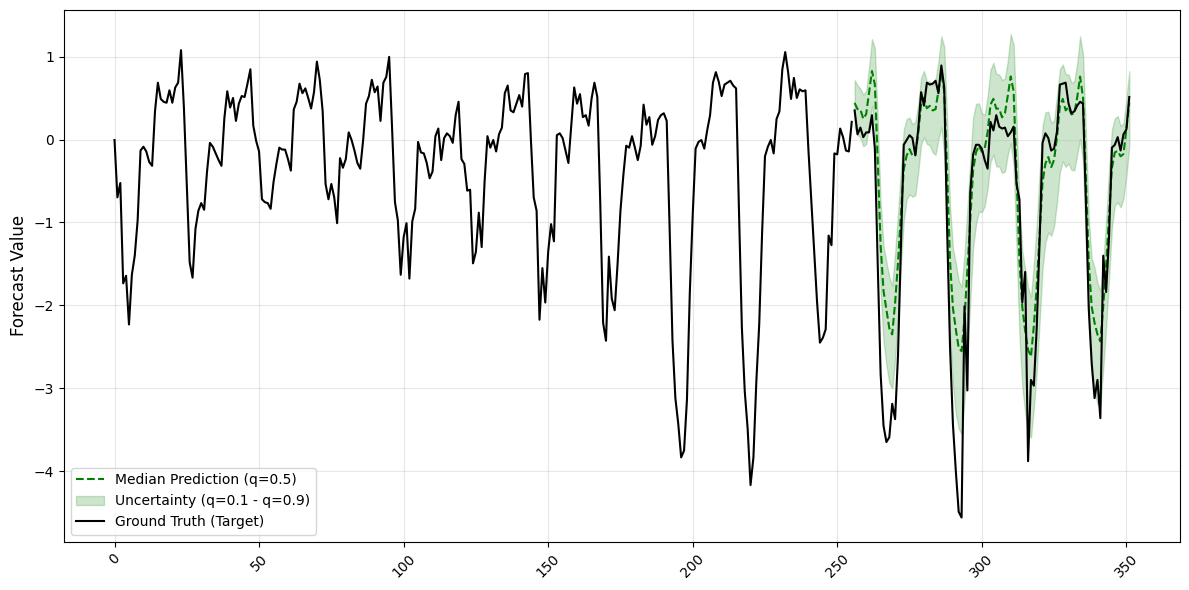

In [107]:
batch_idx = 0
var_idx = 0

plot_results_with_quantile(input_data[batch_idx, var_idx], pred_target[batch_idx, var_idx], quantile_forecasts_list[batch_idx, var_idx])